<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Code Readability Evals</h1>

Arize provides tooling to evaluate LLM applications, including tools to determine the readability or unreadability of code generated by LLM applications.

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to classifying
  generated code as readable or unreadable using datasets with ground-truth
  labels
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [1]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 10

In [2]:
!pip install -qq "arize-phoenix[experimental]" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken

In [3]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from phoenix.experimental.evals import (
    CODE_READABILITY_PROMPT_RAILS_MAP,
    CODE_READABILITY_PROMPT_TEMPLATE
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

/Users/jasonlopatecki/vs_projects/evals_tests/link_evals/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in
addition to an evaluation prompt template against a benchmark datasets of
readable and unreadable code with ground-truth labels. Currently supported
datasets for this task include:

- openai_humaneval_with_readability

In [4]:
dataset_name = "openai_humaneval_with_readability"
df = download_benchmark_dataset(task="code-readability-classification", dataset_name=dataset_name)
df.head()

,Unnamed: 0,task_id,prompt,canonical_solution,test,entry_point,readable,solution
0,0,HumanEval/0,"from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n """""" Check if in given list of numbers, are any two numbers closer to each other than\n given threshold.\n >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n False\n >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n True\n """"""\n","for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n","\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.3) == True\n assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.05) == False\n assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.95) == True\n assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.8) == False\n assert candidate([1.0, 2.0, 3.0, 4.0, 5.0, 2.0], 0.1) == True\n assert candidate([1.1, 2.2, 3.1, 4.1, 5.1], 1.0) == True\n assert candidate([1.1, 2.2, 3.1, 4.1, 5.1], 0.5) == False\n\n",has_close_elements,True,"for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n"
1,1,HumanEval/1,"from typing import List\n\n\ndef separate_paren_groups(paren_string: str) -> List[str]:\n """""" Input to this function is a string containing multiple groups of nested parentheses. Your goal is to\n separate those group into separate strings and return the list of those.\n Separate groups are balanced (each open brace is properly closed) and not nested within each other\n Ignore any spaces in the input string.\n >>> separate_paren_groups('( ) (( )) (( )( ))')\n ['()', '(())', '(()())']\n """"""\n",result = []\n current_string = []\n current_depth = 0\n\n for c in paren_string:\n if c == '(':\n current_depth += 1\n current_string.append(c)\n elif c == ')':\n current_depth -= 1\n current_string.append(c)\n\n if current_depth == 0:\n result.append(''.join(current_string))\n current_string.clear()\n\n return result\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate('(()()) ((())) () ((())()())') == [\n '(()())', '((()))', '()', '((())()())'\n ]\n assert candidate('() (()) ((())) (((())))') == [\n '()', '(())', '((()))', '(((())))'\n ]\n assert candidate('(()(())((())))') == [\n '(()(())((())))'\n ]\n assert candidate('( ) (( )) (( )( ))') == ['()', '(())', '(()())']\n",separate_paren_groups,True,result = []\n current_string = []\n current_depth = 0\n\n for c in paren_string:\n if c == '(':\n current_depth += 1\n current_string.append(c)\n elif c == ')':\n current_depth -= 1\n current_string.append(c)\n\n if current_depth == 0:\n result.append(''.join(current_string))\n current_string.clear()\n\n return result\n
2,2,HumanEval/2,"\n\ndef truncate_number(number: float) -> float:\n """""" Given a positive floating point number, it can be decomposed into\n and integer part (largest integer smaller than given number) and decimals\n (leftover part always smaller than 1).\n\n Return the decimal part of the number.\n >>> truncate_number(3.5)\n 0.5\n """"""\n",return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate(3.5) == 0.5\n assert abs(candidate(1.33) - 0.33) < 1e-6\n assert abs(candidate(123.456) - 0.456) < 1e-6\n",truncate_number,False,return((lambda x: (lambda y: y(x))(lambda f: (lambda x: f(lambda v: x(x)(v)))(lambda y: f(lambda u: y(y)(u)))))(lambda f: (lambda x: f(lambda v: x(x)(v)))(lambda y: f(lambda u: y(y)(u))))(lambda f: lambda x: x if x == 0 else f(x - 1) + 1)(number % 1.0))
3,3,HumanEval/3,"from typing import List\n\n\ndef below_zero(operations: List[int]) -> bool:\n """""" You're given a list of deposit and withdrawal operations on a ban

## Display Binary Readability Classification Template

View the default template used to classify readability. You can tweak this template and evaluate its performance relative to the default.

In [5]:
print(CODE_READABILITY_PROMPT_TEMPLATE)


You are a stern but practical senior software engineer who cares a lot about simplicity and
readability of code. Can you review the following code that was written by another engineer?
Focus on readability of the code. Respond with "readable" if you think the code is readable,
or "unreadable" if the code is unreadable or needlessly complex for what it's trying
to accomplish.

ONLY respond with "readable" or "unreadable"

Task Assignment:
```
{query}
```

Implementation to Evaluate:
```
{code}
```



The template variables are:

- **query:** the coding task asked by a user
- **code:** implementation of the coding task

## Configure the LLM

Configure your OpenAI API key.

In [6]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

Instantiate the LLM and set parameters.

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [7]:
df = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)
df = df.rename(
    columns={"prompt": "query", "solution": "code"},
)

## LLM Evals: Code Readability Classifications GPT-4

Run readability classifications against a subset of the data.

In [8]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [9]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

In [10]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
)["label"]

100%|██████████| 10/10 [00:10<00:00,  1.04s/it]



Evaluate the predictions against human-labeled ground-truth readability labels.

              precision    recall  f1-score   support

    readable       1.00      0.71      0.83         7
  unreadable       0.60      1.00      0.75         3

    accuracy                           0.80        10
   macro avg       0.80      0.86      0.79        10
weighted avg       0.88      0.80      0.81        10



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

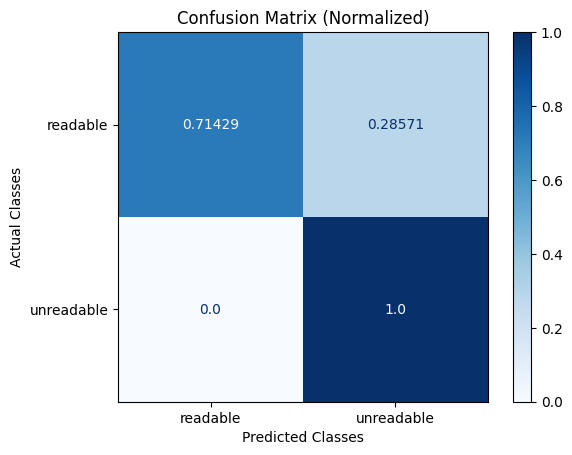

In [11]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_RAILS_MAP).tolist()
readability_classifications = (
    pd.Series(readability_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

print(classification_report(true_labels, readability_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=readability_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Inspecting evaluations

Because the evals are binary classifications, we can easily sample a few rows
where the evals deviated from ground truth and see what the actual code was in
that case.

In [12]:
df["readability"] = readability_classifications
# inspect instances where ground truth was readable but evaluated to unreadable by the LLM
filtered_df = df.query('readable == False and readability == "readable"')

# inspect first 5 rows that meet this condition
result = filtered_df.head(5)
result

,Unnamed: 0,task_id,query,canonical_solution,test,entry_point,readable,code,readability


## Classifications with explanations

When evaluating a dataset for readability, it can be useful to know why the LLM classified text as readable or not. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [13]:
small_df_sample = df.copy().sample(n=5).reset_index(drop=True)
readability_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=CODE_READABILITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
)

OpenAI invocation parameters: {'model': 'gpt-4', 'temperature': 0.0, 'max_tokens': 256, 'frequency_penalty': 0, 'presence_penalty': 0, 'top_p': 1, 'n': 1, 'timeout': None}


 20%|██        | 1/5 [00:03<00:15,  3.76s/it]

- Snapped 'readable' to rail: readable


 40%|████      | 2/5 [00:09<00:15,  5.00s/it]

- Snapped 'readable' to rail: readable


 60%|██████    | 3/5 [00:14<00:10,  5.11s/it]

- Snapped 'unreadable' to rail: unreadable


 80%|████████  | 4/5 [00:20<00:05,  5.31s/it]

- Snapped 'unreadable' to rail: unreadable


100%|██████████| 5/5 [00:24<00:00,  4.88s/it]

- Snapped 'readable' to rail: readable


In [14]:
# Let's view the data
merged_df = pd.merge(
    small_df_sample, readability_classifications_df, left_index=True, right_index=True
)
merged_df[["query", "code", "label", "explanation"]].head()

,query,code,label,explanation
0,"\ndef get_max_triples(n):\n """"""\n You are given a positive integer n. You have to create an integer array a of length n.\n For each i (1 ≤ i ≤ n), the value of a[i] = i * i - i + 1.\n Return the number of triples (a[i], a[j], a[k]) of a where i < j < k, \n and a[i] + a[j] + a[k] is a multiple of 3.\n\n Example :\n Input: n = 5\n Output: 1\n Explanation: \n a = [1, 3, 7, 13, 21]\n The only valid triple is (1, 7, 13).\n """"""\n","A = [i*i - i + 1 for i in range(1,n+1)]\n ans = []\n for i in range(n):\n for j in range(i+1,n):\n for k in range(j+1,n):\n if (A[i]+A[j]+A[k])%3 == 0:\n ans += [(A[i],A[j],A[k])]\n return len(ans)\n",readable,"The code is simple and straightforward. It uses list comprehension to generate the array, and nested loops to find the triples. The variable names could be more descriptive, but the logic is clear and easy to follow."
1,"\ndef triangle_area(a, b, c):\n '''\n Given the lengths of the three sides of a triangle. Return the area of\n the triangle rounded to 2 decimal points if the three sides form a valid triangle. \n Otherwise return -1\n Three sides make a valid triangle when the sum of any two sides is greater \n than the third side.\n Example:\n triangle_area(3, 4, 5) == 6.00\n triangle_area(1, 2, 10) == -1\n '''\n","if a + b <= c or a + c <= b or b + c <= a:\n return -1 \n s = (a + b + c)/2 \n area = (s * (s - a) * (s - b) * (s - c)) ** 0.5\n area = round(area, 2)\n return area\n",readable,"The code is simple and straightforward. It first checks if the given sides can form a triangle, if not it returns -1. Then it calculates the semi-perimeter (s) and uses Heron's formula to calculate the area of the triangle. The area is then rounded to 2 decimal points and returned. The logic is clear and easy to follow."
2,"\n\ndef correct_bracketing(brackets: str):\n """""" brackets is a string of ""<"" and "">"".\n return True if every opening bracket has a corresponding closing bracket.\n\n >>> correct_bracketing(""<"")\n False\n >>> correct_bracketing(""<>"")\n True\n >>> correct_bracketing(""<<><>>"")\n True\n >>> correct_bracketing(""><<>"")\n False\n """"""\n","d=0\nfor b in brackets:\n if b==""<"":d+=1\n else:d-=1\n if d<0:return False\nreturn d==0",unreadable,"The code lacks proper indentation, which makes it hard to follow the logic. Also, the variable names 'd' and 'b' are not descriptive, which makes the code harder to understand. It would be more readable if the variable 'd' was named something like 'bracket_count' and 'b' was named 'bracket'."
3,"\ndef odd_count(lst):\n """"""Given a list of strings, where each string consists of only digits, return a list.\n Each element i of the output should be ""the number of odd elements in the\n string i of the input."" where all the i's should be replaced by the number\n of odd digits in the i'th string of the input.\n\n >>> odd_count(['1234567'])\n [""the number of odd elements 4n the str4ng 4 of the 4nput.""]\n >>> odd_count(['3',""11111111""])\n [""the number of odd elements 1n the str1ng 1 of the 1nput."",\n ""the number of odd elements 8n the str8ng 8 of the 8nput.""]\n """"""\n","res = []\n for arr in lst:\n n = sum(int(d)%2==1 for d in arr)\n res.append(""the number of odd elements "" + str(n) + ""n the str""+ str(n) +""ng ""+ str(n) +"" of the ""+ str(n) +""nput."")\n return res\n",unreadable,The code is unreadable due to the lack of proper variable names and the complex string concatenation. The docstring is also confusing and does not clearly explain the function's purpose. The use of 'n' in the output string is also confusing and does not make sense in the context of the sentence.
4,"\ndef even_odd_count(num):\n """"""Given an integer. return a tuple that has the number of even and odd digits respectively.\n\n Example:\n even_odd_count(-12) ==> (1, 1)\n even_odd_count(123) ==> (1, 2)\n """"""\n","even_count = 0\n odd_count = 0\n for i in str(abs(num)):\n if int(i)%2==0:\n even_count +=1\n else:\n odd_count +

## LLM Evals: Code Readability Classifications GPT-3.5

Run readability classifications against a subset of the data.

In [15]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE,
    model=OpenAIModel(
        model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20, max_retries=0
    ),
    rails=rails,
)["label"]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


              precision    recall  f1-score   support

    readable       0.88      1.00      0.93         7
  unreadable       1.00      0.67      0.80         3

    accuracy                           0.90        10
   macro avg       0.94      0.83      0.87        10
weighted avg       0.91      0.90      0.89        10



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

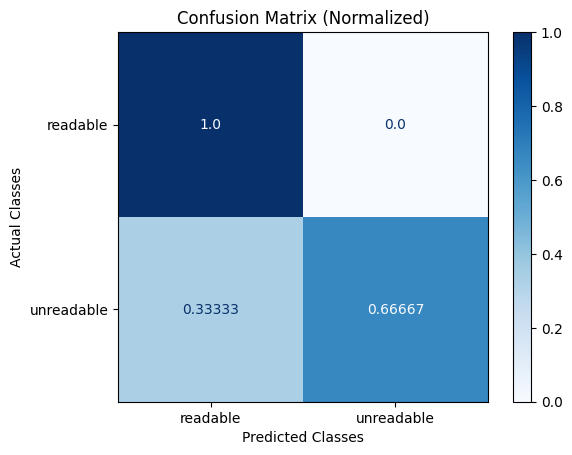

In [16]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_RAILS_MAP).tolist()
readability_classifications = (
    pd.Series(readability_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

print(classification_report(true_labels, readability_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=readability_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

# Preview: GPT-4 Turbo

In [17]:
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE,
    model=OpenAIModel(model_name="gpt-4-1106-preview", temperature=0.0),
    rails=rails,
)["label"]

100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


              precision    recall  f1-score   support

    readable       1.00      0.71      0.83         7
  unreadable       0.60      1.00      0.75         3

    accuracy                           0.80        10
   macro avg       0.80      0.86      0.79        10
weighted avg       0.88      0.80      0.81        10



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

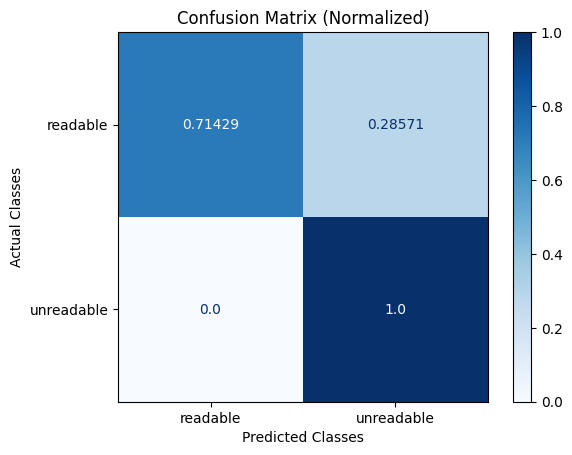

In [18]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_RAILS_MAP).tolist()
readability_classifications = (
    pd.Series(readability_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

print(classification_report(true_labels, readability_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=readability_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)